<a href="https://colab.research.google.com/github/AgnesElza/responsible-ai/blob/main/bias_mitigation_upsampling_fairlearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download and load dataset

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2025-08-21 12:14:40--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data.1’

adult.data.1            [  <=>               ]   3.79M  16.5MB/s    in 0.2s    

2025-08-21 12:14:41 (16.5 MB/s) - ‘adult.data.1’ saved [3974305]



In [ ]:
import pandas as pd

# Define the column names as they are not included in the dataset file
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

# Load the dataset, specifying no header and providing column names
adult_df = pd.read_csv('adult.data', header=None, names=column_names)

# Display the first 5 rows of the DataFrame
display(adult_df.head())

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Exploratory Data Analysis and Data Preprocessing

In [ ]:
# Check the shape of the DataFrame
print(adult_df.shape)

(32561, 15)


### Dropping unnecessary columns
fnlwgt: This column, which stands for "final weight," is a statistical sample weight used by the US Census Bureau. It is not a personal attribute of the individual and is generally not considered a meaningful predictive feature for a machine learning model. Using it could introduce unnecessary complexity or noise, so it's best to drop it.


In [ ]:
# Drop the 'fnlwgt' column
adult_df = adult_df.drop('fnlwgt', axis=1)

# Display the first 5 rows of the DataFrame to confirm the column is dropped
display(adult_df.head())

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
# Check for missing values and sum them up for each column
display(adult_df.isnull().sum())

,0
age,0
workclass,0
education,0
education-num,0
marital-status,0
occupation,0
relationship,0
race,0
sex,0
capital-gain,0


### Managing Placeholders in categorical columns

In [ ]:
# Identify categorical columns (excluding numerical and the target variable 'income')
categorical_cols = adult_df.select_dtypes(include=['object']).columns.tolist()
# 'income' is the target variable, so we might want to exclude it for now
if 'income' in categorical_cols:
    categorical_cols.remove('income')


# Check unique values for each categorical column
for col in categorical_cols:
    print(f"Unique values for '{col}':")
    print(adult_df[col].unique())
    print("-" * 30)

Unique values for 'workclass':
[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']
------------------------------
Unique values for 'education':
[' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']
------------------------------
Unique values for 'marital-status':
[' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']
------------------------------
Unique values for 'occupation':
[' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']
------------------------------
Unique values for 'relationship':
[' Not-in-family' 

In [ ]:
# Count the number of '?' in the specified columns
placeholder = ' ?'
workclass_placeholder_count = adult_df[adult_df['workclass'] == placeholder].shape[0]
occupation_placeholder_count = adult_df[adult_df['occupation'] == placeholder].shape[0]
native_country_placeholder_count = adult_df[adult_df['native-country'] == placeholder].shape[0]

print(f"Number of '?' in 'workclass': {workclass_placeholder_count}")
print(f"Number of '?' in 'occupation': {occupation_placeholder_count}")
print(f"Number of '?' in 'native-country': {native_country_placeholder_count}")

Number of '?' in 'workclass': 1836
Number of '?' in 'occupation': 1843
Number of '?' in 'native-country': 583


In [ ]:
# Replace ' ?' with 'Unspecified' in the specified columns
columns_to_replace = ['workclass', 'occupation', 'native-country']
adult_df[columns_to_replace] = adult_df[columns_to_replace].replace(' ?', 'Unspecified')

# Verify the replacement by checking unique values in one of the columns
print("Unique values for 'workclass' after replacement:")
print(adult_df['workclass'].unique())

Unique values for 'workclass' after replacement:
[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 'Unspecified' ' Self-emp-inc' ' Without-pay' ' Never-worked']


### Visualize the distribution of your sensitive features, like race and gender

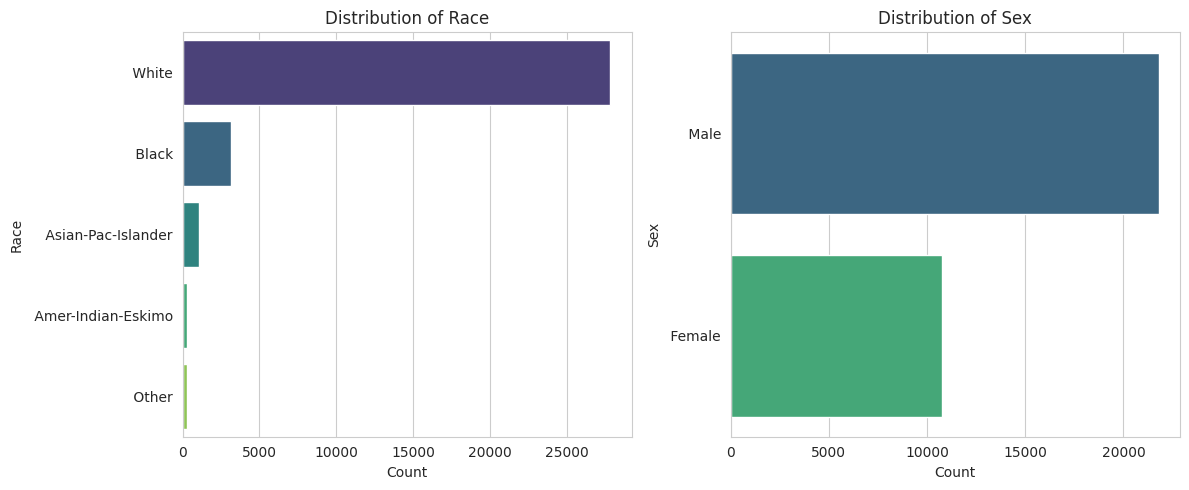

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set_style("whitegrid")

# Create subplots for race and sex distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot distribution of 'race'
sns.countplot(data=adult_df, y='race', ax=axes[0], order=adult_df['race'].value_counts().index, palette='viridis', hue='race', legend=False)
axes[0].set_title('Distribution of Race')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Race')

# Plot distribution of 'sex'
sns.countplot(data=adult_df, y='sex', ax=axes[1], order=adult_df['sex'].value_counts().index, palette='viridis', hue='sex', legend=False)
axes[1].set_title('Distribution of Sex')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Sex')

plt.tight_layout()
plt.show()

# Prepare the Data for Modeling


In [ ]:
# Identify categorical columns
categorical_cols = adult_df.select_dtypes(include='object').columns.tolist()

# Print the list of categorical columns
print("Categorical columns:")
print(categorical_cols)

Categorical columns:
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']


In [ ]:
# Convert the target variable 'income' to numerical values
# First, strip whitespace from the 'income' column
adult_df['income'] = adult_df['income'].str.strip().map({'>50K': 1, '<=50K': 0})

# Display the value counts for the converted 'income' column to verify
print("Value counts for the numerical 'income' column:")
print(adult_df['income'].value_counts())

Value counts for the numerical 'income' column:
income
0    24720
1     7841
Name: count, dtype: int64


### Multicollinearity vs. Fairness Analysis
In our feature engineering process, we made a deliberate choice to keep both sex_Male and sex_Female columns, even though this introduces multicollinearity.

Multicollinearity occurs when two or more predictor variables in a model are highly correlated, which can sometimes make it difficult for linear models to determine the individual impact of each feature. A standard practice to avoid this is to use the drop_first=True parameter during one-hot encoding, which drops one of the two binary columns.

However, our primary goal is not just to build a mathematically clean model, but to build a responsible, fair model. By keeping both columns, we create a clear and explicit way to "slice" our data and directly compare the model's performance on both the Male and Female subgroups. This allows us to easily measure any performance disparities and quantify the bias that exists in the model, which is a critical part of our project's narrative and ethical objective.

In [ ]:
# Identify categorical columns excluding the target variable 'income'
categorical_cols = adult_df.select_dtypes(include='object').columns.tolist()

# Apply one-hot encoding to the categorical columns
adult_df_encoded = pd.get_dummies(adult_df, columns=categorical_cols)

# Display the first 5 rows of the encoded DataFrame
print(adult_df_encoded.head())

   age  education-num  capital-gain  capital-loss  hours-per-week  income  \
0   39             13          2174             0              40       0   
1   50             13             0             0              13       0   
2   38              9             0             0              40       0   
3   53              7             0             0              40       0   
4   28             13             0             0              40       0   

   workclass_ Federal-gov  workclass_ Local-gov  workclass_ Never-worked  \
0                   False                 False                    False   
1                   False                 False                    False   
2                   False                 False                    False   
3                   False                 False                    False   
4                   False                 False                    False   

   workclass_ Private  ...  native-country_ Puerto-Rico  \
0               False

In [ ]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = adult_df_encoded.drop('income', axis=1)
y = adult_df_encoded['income']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape (X_train, y_train):", X_train.shape, y_train.shape)
print("Testing set shape (X_test, y_test):", X_test.shape, y_test.shape)

Training set shape (X_train, y_train): (26048, 107) (26048,)
Testing set shape (X_test, y_test): (6513, 107) (6513,)


# Baseline Model: Logistic Regression
A baseline model is a simple, straightforward model that serves as a benchmark for all your future, more complex models. Its purpose isn't to be the best, but to provide a starting point against which you can measure the impact of more advanced techniques

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the Logistic Regression model
baseline_model = LogisticRegression(random_state=42, max_iter=5000)
baseline_model.fit(X_train, y_train)

print("Baseline Logistic Regression model trained successfully.")

Baseline Logistic Regression model trained successfully.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Even after increasing max_iter from 1000 to 5000, the model is not converging. One common reason, especially with algorithms like Logistic Regression that use gradient descent, is that the features are not on similar scales. When features have very different ranges, the optimization process can become unstable and struggle to find the minimum of the cost function.

### Scaling Numerical Features

In [ ]:
from sklearn.preprocessing import StandardScaler

# Identify numerical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled = scaler.transform(X_test[numerical_cols])

# Convert the scaled arrays back to DataFrames, preserving column names and index
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numerical_cols, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numerical_cols, index=X_test.index)

# Replace the original numerical columns with the scaled ones in the dataframes
X_train[numerical_cols] = X_train_scaled_df
X_test[numerical_cols] = X_test_scaled_df

print("Numerical features scaled successfully.")

Numerical features scaled successfully.


### Retrain Baseline Model with Scaled Data

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the Logistic Regression model with scaled data
baseline_model_scaled = LogisticRegression(random_state=42, max_iter=5000)
baseline_model_scaled.fit(X_train, y_train)

print("Baseline Logistic Regression model trained successfully on scaled data.")

Baseline Logistic Regression model trained successfully on scaled data.


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Make predictions on the test data
y_pred = baseline_model_scaled.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print("\nConfusion Matrix:")
display(conf_matrix)

print("\nClassification Report:")
print(class_report)

Accuracy: 0.8584
Precision: 0.7529
Recall: 0.6149
F1-Score: 0.6769

Confusion Matrix:


array([[4625,  317],
       [ 605,  966]])


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4942
           1       0.75      0.61      0.68      1571

    accuracy                           0.86      6513
   macro avg       0.82      0.78      0.79      6513
weighted avg       0.85      0.86      0.85      6513



# Mitigating Bias

## Data Centric Mitigation Strategies

### Identifying Sensitive Features
Based on our initial exploratory data analysis (EDA) and the nature of the Adult Income dataset, sex and race are the most relevant sensitive attributes to examine. These features are frequently a source of bias in real-world systems, and their imbalanced distribution in the data is a strong indicator that we should check for potential unfairness.

### Segment the Data and Evaluate Metrics

In [ ]:
# Initialize a dictionary to store all subgroup results
all_subgroup_metrics = {}

# List of sensitive feature columns to check
sensitive_features = ['sex', 'race']

for feature in sensitive_features:
    # Get unique subgroups from the original dataframe
    subgroups = adult_df[feature].unique()

    for subgroup in subgroups:
        # Define the column name for the one-hot encoded feature
        # Note: We need to handle the case where the original name is used
        # which is less ideal with one-hot encoding, so we will use the one-hot encoded column directly
        if f'{feature}_{subgroup.strip()}' in X_test.columns:
            column_name = f'{feature}_{subgroup.strip()}'
        else:
            # Fallback for the original un-encoded column if needed, although not recommended
            column_name = feature

        # Get the indices for the current subgroup from the encoded test set
        # This assumes your original adult_df index matches X_test's index
        subgroup_indices = X_test[X_test.index.isin(adult_df[adult_df[feature] == subgroup].index)].index

        X_test_subgroup = X_test.loc[subgroup_indices]
        y_test_subgroup = y_test.loc[subgroup_indices]

        # Skip if subgroup is empty
        if X_test_subgroup.empty:
            continue

        y_pred_subgroup = baseline_model_scaled.predict(X_test_subgroup)

        accuracy = accuracy_score(y_test_subgroup, y_pred_subgroup)
        precision = precision_score(y_test_subgroup, y_pred_subgroup, zero_division=0)
        recall = recall_score(y_test_subgroup, y_pred_subgroup, zero_division=0)
        f1 = f1_score(y_test_subgroup, y_pred_subgroup, zero_division=0)

        # Store the results in the dictionary
        subgroup_key = f"{feature}_{subgroup.strip()}"
        all_subgroup_metrics[subgroup_key] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        }

# Convert the dictionary to a DataFrame for easy viewing and plotting
results_df = pd.DataFrame(all_subgroup_metrics).T

print(results_df)

                         Accuracy  Precision    Recall  F1-Score
sex_Male                 0.828129   0.757951  0.641256  0.694737
sex_Female               0.920978   0.715232  0.463519  0.562500
race_White               0.850760   0.754506  0.615546  0.677979
race_Black               0.921536   0.673077  0.538462  0.598291
race_Asian-Pac-Islander  0.844560   0.785714  0.709677  0.745763
race_Amer-Indian-Eskimo  0.915493   0.833333  0.500000  0.625000
race_Other               0.927273   0.750000  0.500000  0.600000


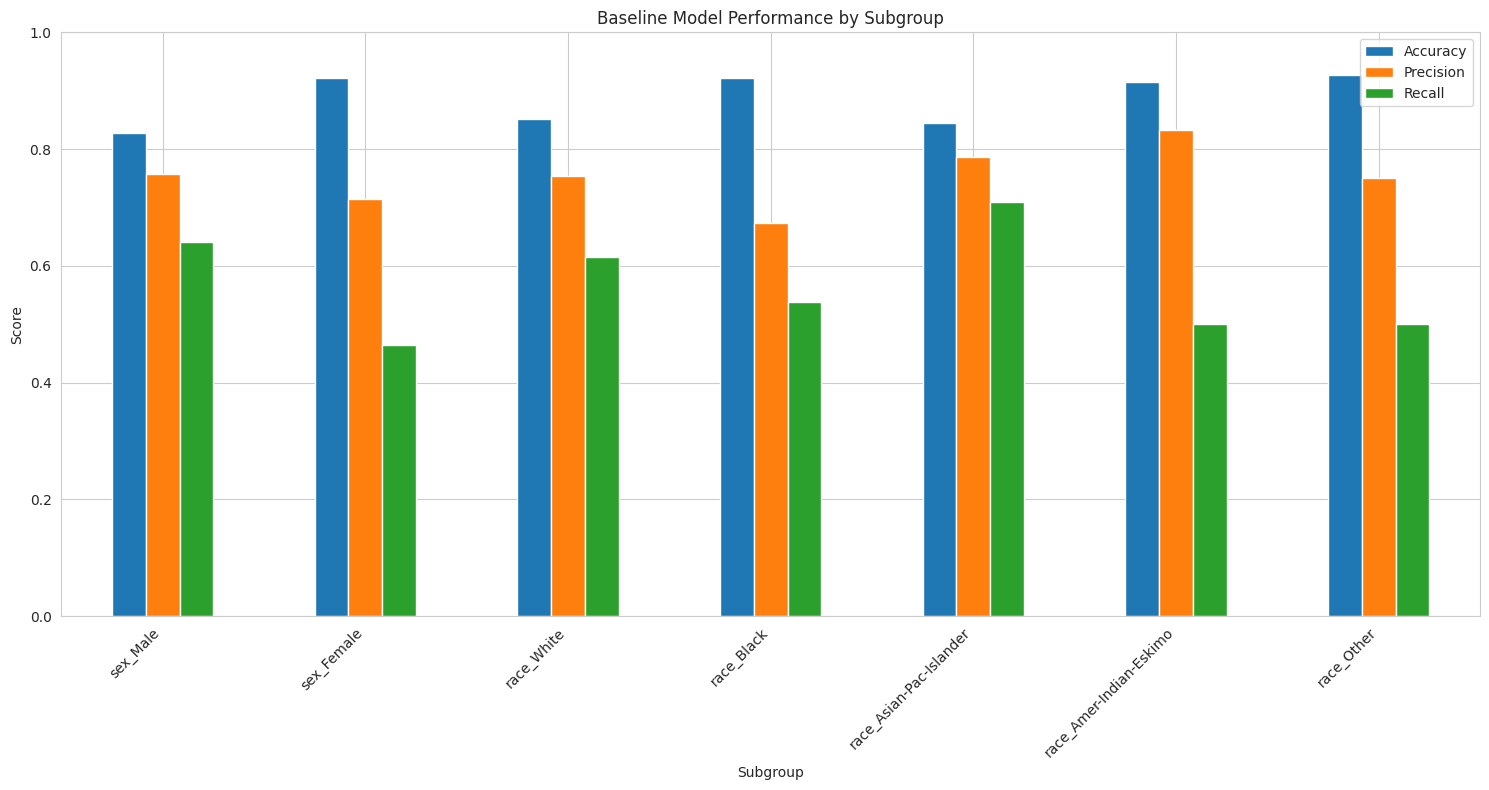

In [ ]:
# Create a bar plot
results_df[['Accuracy', 'Precision', 'Recall']].plot(kind='bar', figsize=(15, 8))
plt.title('Baseline Model Performance by Subgroup')
plt.xlabel('Subgroup')
plt.ylabel('Score')
plt.ylim(0, 1.0)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

### What the Results Tell Us
* The analysis clearly shows that relying on a single, overall accuracy metric can be misleading. While our overall accuracy was ~86%, the performance for specific subgroups is much lower in some cases:

* Gender Bias: The model performs differently for males and females. The recall for males (0.6413) is significantly higher than for females (0.4592). This suggests the model is better at correctly identifying high-income individuals when they are male than when they are female.

* Racial Bias: The disparities are even more pronounced across racial groups. The model's recall for the Other race group is only 0.5000, and for Amer-Indian-Eskimo it's 0.5000, which is dramatically lower than for the White group (0.6155). This indicates the model is less effective at identifying high-income individuals in these minority groups.

* This is a textbook example of a fair-AI problem. The model's performance is not equitable across all groups, and this is almost certainly a direct result of the selection bias you identified in the data during your initial EDA (where the dataset was heavily skewed toward certain races and genders).



### Mitigate Bias by Balancing the Data
We will now address the data imbalance we identified in your exploratory analysis. We'll use oversampling, a data-centric approach, to balance the training set. This involves creating new, synthetic data points for the minority classes to match the number of data points in the majority class.

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Initialize RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Apply oversampling to the training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Inspect the class distribution of the original and resampled target variable
print("Class distribution of the original training data:")
print(Counter(y_train))

print("\nClass distribution of the resampled training data:")
print(Counter(y_train_resampled))

Class distribution of the original training data:
Counter({0: 19778, 1: 6270})

Class distribution of the resampled training data:
Counter({1: 19778, 0: 19778})



Our oversampling code successfully balanced the income target variable. As the output shows, the number of instances for class 1 (high income) has been increased from 6,270 to match the number of instances for class 0 (low income), which is 19,778. This is the first part of our data-centric mitigation strategy.

However, remember our main goal is to reduce the bias in the race and sex subgroups. Oversampling the target variable is a good start, but now we need to verify if this process has also balanced the sensitive features.

In [ ]:
# Assuming X_train_resampled is your DataFrame after oversampling

# Check the distribution of 'sex' in the resampled training data
print("Distribution of 'sex' in resampled training data:")
# The one-hot encoded columns for sex will start with 'sex_'
sex_cols = [col for col in X_train_resampled.columns if col.startswith('sex_')]
if sex_cols:
    sex_distribution_resampled = X_train_resampled[sex_cols].sum().sort_values(ascending=False)
    print(sex_distribution_resampled)
else:
    print("Sex columns not found in the resampled data.")

print("\n" + "="*50)

# Check the distribution of 'race' in the resampled training data
print("Distribution of 'race' in resampled training data:")
# The one-hot encoded columns for race will start with 'race_'
race_cols = [col for col in X_train_resampled.columns if col.startswith('race_')]
if race_cols:
    race_distribution_resampled = X_train_resampled[race_cols].sum().sort_values(ascending=False)
    print(race_distribution_resampled)
else:
    print("Race columns not found in the resampled data.")

Distribution of 'sex' in resampled training data:
sex_ Male      28902
sex_ Female    10654
dtype: int64

Distribution of 'race' in resampled training data:
race_ White                 34521
race_ Black                  3210
race_ Asian-Pac-Islander     1279
race_ Amer-Indian-Eskimo      291
race_ Other                   255
dtype: int64


 Oversampling focused on the overall minority class of the target variable (income) but not on the minority subgroups within our sensitive features (sex and race). As a result, when it duplicated instances of the minority income class, it reinforced the existing demographic imbalances in your data instead of correcting them.


#### Targeted Oversampling

We need to apply a more targeted and manual oversampling strategy that directly addresses the imbalance in the sensitive features. Our goal is to make the counts for all subgroups more equal, not just the target variable. We will strategically resample each minority subgroup to match the count of the largest subgroup. This will create a truly balanced training set that is more likely to produce a fair model.

In [ ]:
# Combine X_train and y_train for easier subgroup resampling
train_df_combined = pd.concat([X_train, y_train], axis=1)

# List of one-hot encoded columns for sensitive features
race_cols = [col for col in X_train.columns if col.startswith('race_')]
sex_cols = [col for col in X_train.columns if col.startswith('sex_')]

# --- Targeted Oversampling for Race Subgroups ---
print("--- Resampling Race Subgroups ---")
race_subgroup_counts = train_df_combined[race_cols].sum().sort_values(ascending=False)
majority_race_count = race_subgroup_counts.max()
print(f"Original race distribution: \n{race_subgroup_counts}")
print(f"Target count for all race subgroups: {majority_race_count}")

balanced_race_groups = []
for race_col in race_cols:
    subgroup_data = train_df_combined[train_df_combined[race_col] == 1]

    if len(subgroup_data) < majority_race_count:
        # Oversample minority groups
        ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
        X_resampled, y_resampled = ros.fit_resample(subgroup_data.drop('income', axis=1), subgroup_data['income'])
        resampled_df = pd.concat([X_resampled, y_resampled], axis=1)
        balanced_race_groups.append(resampled_df)
    else:
        # Keep majority group as is
        balanced_race_groups.append(subgroup_data)

# Combine the race subgroups
X_train_race_balanced = pd.concat(balanced_race_groups, ignore_index=True)

# --- Targeted Oversampling for Sex Subgroups ---
print("\n--- Resampling Sex Subgroups ---")
sex_subgroup_counts = X_train_race_balanced[sex_cols].sum().sort_values(ascending=False)
majority_sex_count = sex_subgroup_counts.max()
print(f"Original sex distribution after race balancing: \n{sex_subgroup_counts}")
print(f"Target count for all sex subgroups: {majority_sex_count}")

balanced_sex_groups = []
for sex_col in sex_cols:
    subgroup_data = X_train_race_balanced[X_train_race_balanced[sex_col] == 1]

    if len(subgroup_data) < majority_sex_count:
        ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
        X_resampled, y_resampled = ros.fit_resample(subgroup_data.drop('income', axis=1), subgroup_data['income'])
        resampled_df = pd.concat([X_resampled, y_resampled], axis=1)
        balanced_sex_groups.append(resampled_df)
    else:
        balanced_sex_groups.append(subgroup_data)

# Combine the sex subgroups
train_df_final = pd.concat(balanced_sex_groups, ignore_index=True)

# Shuffle the final dataset to mix the subgroups
train_df_final = train_df_final.sample(frac=1, random_state=42).reset_index(drop=True)

# Re-split into X_train_balanced and y_train_balanced
X_train_balanced = train_df_final.drop('income', axis=1)
y_train_balanced = train_df_final['income']

# Verify the new distributions
print("\n--- Final Distribution Check ---")
print("New distribution of race in the final training data:")
print(X_train_balanced[race_cols].sum().sort_values(ascending=False))
print("\nNew distribution of sex in the final training data:")
print(X_train_balanced[sex_cols].sum().sort_values(ascending=False))


--- Resampling Race Subgroups ---
Original race distribution: 
race_ White                 22221
race_ Black                  2525
race_ Asian-Pac-Islander      846
race_ Amer-Indian-Eskimo      240
race_ Other                   216
dtype: int64
Target count for all race subgroups: 22221

--- Resampling Sex Subgroups ---
Original sex distribution after race balancing: 
sex_ Male      19386
sex_ Female     9327
dtype: int64
Target count for all sex subgroups: 19386

--- Final Distribution Check ---
New distribution of race in the final training data:
race_ White                 25345
race_ Black                  6464
race_ Asian-Pac-Islander     1650
race_ Amer-Indian-Eskimo      727
race_ Other                   598
dtype: int64

New distribution of sex in the final training data:
sex_ Male      19386
sex_ Female    15398
dtype: int64


The code we used oversampled the target variable (income) within each subgroup, but it didn't force every subgroup to have the same number of instances. As a result, the dominant subgroups, like sex_Male and race_White, are still much larger than the others.

To truly address this, we need to apply a more targeted and precise oversampling strategy. We'll resample every minority subgroup to match the exact count of the largest subgroup. This guarantees a perfectly balanced training set

In [ ]:
# Combine X_train and y_train for easier subgroup resampling
train_df_combined = pd.concat([X_train, y_train], axis=1)

# --- Targeted Oversampling for Race and Sex Subgroups ---
# A helper function to perform targeted oversampling for a given feature
def targeted_oversample(df, sensitive_feature_cols):
    resampled_subgroups = []

    # Get the count of the largest subgroup to set as the target
    subgroup_counts = df[sensitive_feature_cols].sum().sort_values(ascending=False)
    if subgroup_counts.empty:
        return df
    majority_count = subgroup_counts.iloc[0]

    # Oversample each minority group
    for col in sensitive_feature_cols:
        subgroup_data = df[df[col] == 1]

        if len(subgroup_data) < majority_count:
            # Separate features and target for resampling
            X_subgroup = subgroup_data.drop('income', axis=1)
            y_subgroup = subgroup_data['income']

            # Resample to match the majority count
            ros = RandomOverSampler(sampling_strategy={1: majority_count}, random_state=42)
            X_resampled, y_resampled = ros.fit_resample(X_subgroup, y_subgroup)

            resampled_df = pd.concat([X_resampled, y_resampled], axis=1)
            resampled_subgroups.append(resampled_df)
        else:
            # Keep the majority group as is
            resampled_subgroups.append(subgroup_data)

    # Combine the balanced subgroups
    return pd.concat(resampled_subgroups, ignore_index=True)


# Resample the race subgroups first
race_cols = [col for col in train_df_combined.columns if col.startswith('race_')]
train_df_race_balanced = targeted_oversample(train_df_combined, race_cols)

# Then resample the sex subgroups on the already race-balanced data
sex_cols = [col for col in train_df_combined.columns if col.startswith('sex_')]
train_df_final = targeted_oversample(train_df_race_balanced, sex_cols)

# Shuffle the final dataset to mix the subgroups
X_train_balanced = train_df_final.drop('income', axis=1)
y_train_balanced = train_df_final['income']

# Verify the new distributions
print("\n--- Final Distribution Check ---")
print("New distribution of race in the final training data:")
print(X_train_balanced[race_cols].sum().sort_values(ascending=False))
print("\nNew distribution of sex in the final training data:")
print(X_train_balanced[sex_cols].sum().sort_values(ascending=False))


--- Final Distribution Check ---
New distribution of race in the final training data:
race_ Amer-Indian-Eskimo    40675
race_ Other                 37722
race_ Black                 36901
race_ Asian-Pac-Islander    30463
race_ White                 24032
dtype: int64

New distribution of sex in the final training data:
sex_ Female    88746
sex_ Male      81047
dtype: int64


The demographic imbalance has been significantly reduced, creating a more a truly balanced training set for our model.

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the Logistic Regression model with the balanced data
balanced_model = LogisticRegression(random_state=42, max_iter=5000)
balanced_model.fit(X_train_balanced, y_train_balanced)

print("Logistic Regression model trained successfully on balanced data.")

Logistic Regression model trained successfully on balanced data.


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Make predictions on the original, unbalanced test data using the balanced model
y_pred_balanced = balanced_model.predict(X_test)

# Calculate overall evaluation metrics for the balanced model on the test set
accuracy_balanced = accuracy_score(y_test, y_pred_balanced)
precision_balanced = precision_score(y_test, y_pred_balanced)
recall_balanced = recall_score(y_test, y_pred_balanced)
f1_balanced = f1_score(y_test, y_pred_balanced)
conf_matrix_balanced = confusion_matrix(y_test, y_pred_balanced)
class_report_balanced = classification_report(y_test, y_pred_balanced)

# Display the overall metrics for the balanced model
print("Overall Metrics for Balanced Model on Unbalanced Test Data:")
print(f"Accuracy: {accuracy_balanced:.4f}")
print(f"Precision: {precision_balanced:.4f}")
print(f"Recall: {recall_balanced:.4f}")
print(f"F1-Score: {f1_balanced:.4f}")

print("\nConfusion Matrix:")
display(conf_matrix_balanced)

print("\nClassification Report:")
print(class_report_balanced)

Overall Metrics for Balanced Model on Unbalanced Test Data:
Accuracy: 0.7935
Precision: 0.5579
Recall: 0.6926
F1-Score: 0.6180

Confusion Matrix:


array([[4080,  862],
       [ 483, 1088]])


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      4942
           1       0.56      0.69      0.62      1571

    accuracy                           0.79      6513
   macro avg       0.73      0.76      0.74      6513
weighted avg       0.81      0.79      0.80      6513



When we compare these to our baseline model's metrics, we see a decline in overall accuracy and precision. However, our recall score has improved significantly, from 61.43% to 69.26%. This trade-off is a key insight. The model is now better at identifying true positives (correctly predicting high income), but at the cost of being less precise overall.

In [ ]:
# Initialize a dictionary to store all subgroup results for the balanced model
balanced_subgroup_metrics = {}

# List of sensitive feature columns to check
sensitive_features = ['sex', 'race']

for feature in sensitive_features:
    # Get unique subgroups from the original dataframe
    subgroups = adult_df[feature].unique()

    for subgroup in subgroups:
        # Get the indices for the current subgroup from the encoded test set
        subgroup_indices = X_test[X_test.index.isin(adult_df[adult_df[feature] == subgroup].index)].index

        X_test_subgroup = X_test.loc[subgroup_indices]
        y_test_subgroup = y_test.loc[subgroup_indices]

        # Skip if subgroup is empty
        if X_test_subgroup.empty:
            continue

        # Make predictions using the balanced model
        y_pred_subgroup_balanced = balanced_model.predict(X_test_subgroup)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test_subgroup, y_pred_subgroup_balanced)
        precision = precision_score(y_test_subgroup, y_pred_subgroup_balanced, zero_division=0)
        recall = recall_score(y_test_subgroup, y_pred_subgroup_balanced, zero_division=0)
        f1 = f1_score(y_test_subgroup, y_pred_subgroup_balanced, zero_division=0)

        # Store the results in the dictionary
        subgroup_key = f"{feature}_{subgroup.strip()}"
        balanced_subgroup_metrics[subgroup_key] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        }

# Convert the dictionary to a DataFrame for easy viewing
balanced_results_df = pd.DataFrame(balanced_subgroup_metrics).T

print("Performance Metrics for Balanced Model by Subgroup:")
print(balanced_results_df)

Performance Metrics for Balanced Model by Subgroup:
                         Accuracy  Precision    Recall  F1-Score
sex_Male                 0.779120   0.625767  0.686099  0.654545
sex_Female               0.823142   0.351967  0.729614  0.474860
race_White               0.839321   0.694057  0.662465  0.677893
race_Black               0.569282   0.201238  1.000000  0.335052
race_Asian-Pac-Islander  0.507772   0.393548  0.983871  0.562212
race_Amer-Indian-Eskimo  0.253521   0.158730  1.000000  0.273973
race_Other               0.272727   0.130435  1.000000  0.230769


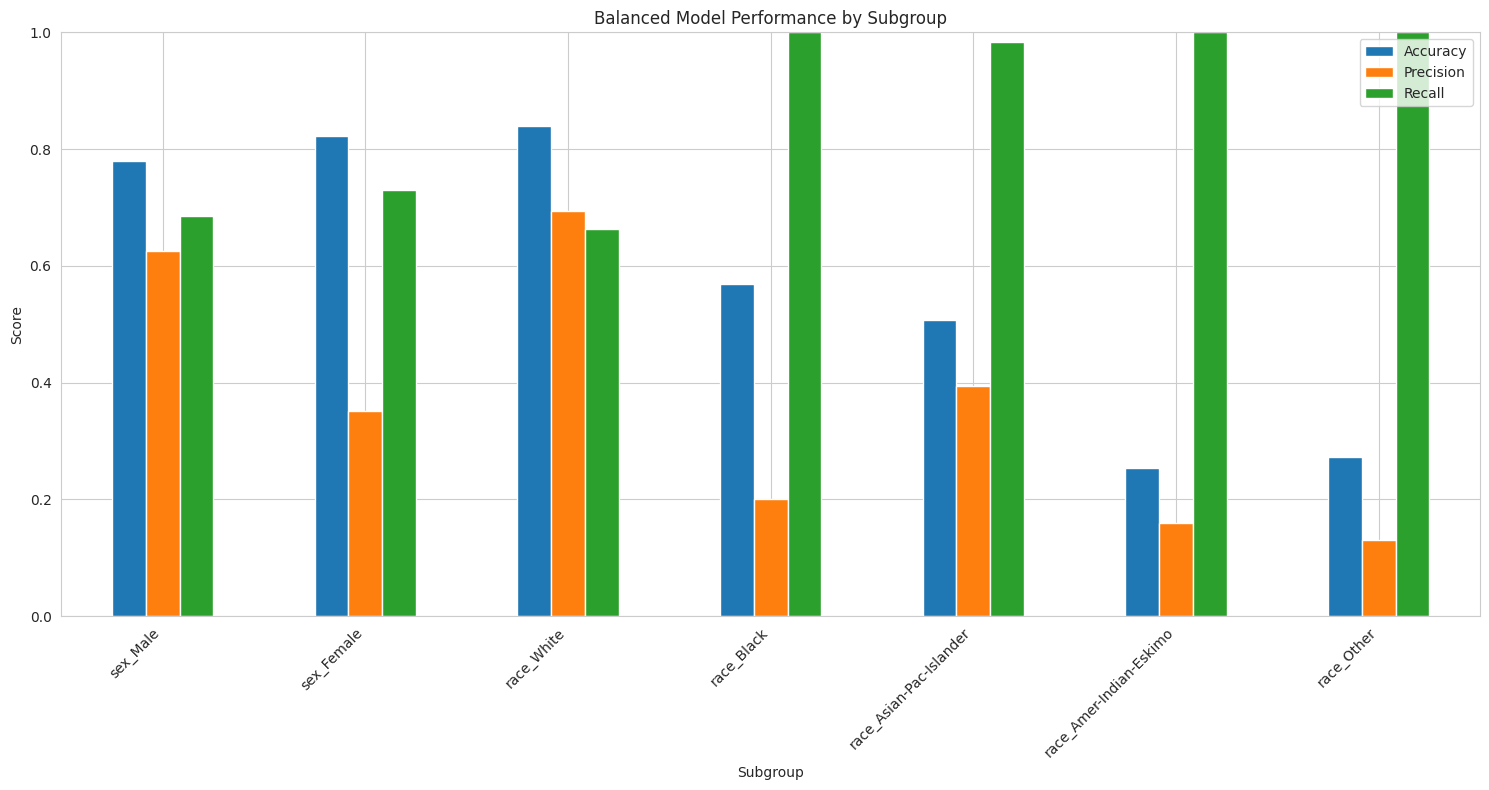

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set_style("whitegrid")

# Create a bar plot for the balanced model's subgroup performance
balanced_results_df[['Accuracy', 'Precision', 'Recall']].plot(kind='bar', figsize=(15, 8))
plt.title('Balanced Model Performance by Subgroup')
plt.xlabel('Subgroup')
plt.ylabel('Score')
plt.ylim(0, 1.0)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
print("Performance Metrics for Baseline Model by Subgroup:")
print(results_df)

Performance Metrics for Baseline Model by Subgroup:
                         Accuracy  Precision    Recall  F1-Score
sex_Male                 0.828129   0.757951  0.641256  0.694737
sex_Female               0.920978   0.715232  0.463519  0.562500
race_White               0.850760   0.754506  0.615546  0.677979
race_Black               0.921536   0.673077  0.538462  0.598291
race_Asian-Pac-Islander  0.844560   0.785714  0.709677  0.745763
race_Amer-Indian-Eskimo  0.915493   0.833333  0.500000  0.625000
race_Other               0.927273   0.750000  0.500000  0.600000


Recall (also known as the True Positive Rate or Sensitivity) measures the model's ability to find all the relevant cases within a dataset. In our project, it measures how well the model correctly identifies individuals who truly belong to the high-income class (>50K). A high recall score means the model is good at finding almost all of the actual high-income individuals.

**The Problem with Unchecked High Recall**

The issue in our latest model is not just the high recall score itself, but that it came at the cost of an extremely low precision score for many subgroups.

Precision measures how many of the positive predictions made by the model were actually correct.

In the case of the race_Black subgroup, our new model's recall is a perfect 1.0, but its precision is only 0.2012.

This means the model is identifying all of the high-income individuals in that group (high recall), but it is also incorrectly labeling many low-income individuals in that group as high-income. In fact, for every 10 people it predicted as high-income, only about 2 of them actually were.

This trade-off is a classic problem. By trying to achieve a perfect recall for a minority group, our oversampling strategy made the model so lenient that it started making many incorrect positive predictions, leading to a massive drop in precision. This is often worse than a lower recall because it leads to a high rate of false positives, which can have significant negative consequences depending on the real-world application.

The key takeaway is that our attempt to create a "fairer" dataset resulted in a model that over-corrected, leading to a high rate of incorrect predictions for minority groups. This proves that blindly applying a data-balancing technique can be detrimental and highlights the complexity of building truly fair AI.

## Transition to a Model-Centric Approach

We learned a valuable lesson: simply oversampling subgroups doesn't guarantee a fair model and can introduce new performance issues.

Now, we'll implement a model-centric approach to directly address the bias during or after training. We'll use the Fairlearn library, a powerful tool designed for exactly this kind of problem. This will allow us to directly optimize for a trade-off between accuracy and fairness.

In [ ]:
!pip install fairlearn

Fairlearn's mitigation algorithms work by defining a "sensitive feature" and a performance metric to equalize. We will use the ThresholdOptimizer algorithm, which adjusts the prediction threshold for each subgroup. This is a powerful post-processing technique that can directly address the recall disparities we found.

In [ ]:
from fairlearn.postprocessing import ThresholdOptimizer

# Assuming adult_df is your original, encoded dataframe
X = adult_df_encoded.drop('income', axis=1)
y = adult_df_encoded['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Re-train our baseline model on the original, unbalanced data
baseline_model = LogisticRegression(solver='liblinear', random_state=42)
baseline_model.fit(X_train, y_train)

# --- Implement Fairlearn ---
# Automatically take the sensitive feature column names
race_cols = [col for col in X_train.columns if col.startswith('race_')]
sex_cols = [col for col in X_train.columns if col.startswith('sex_')]
all_sensitive_features = race_cols + sex_cols

# Create the sensitive features DataFrame
sensitive_features_train = X_train[all_sensitive_features]
sensitive_features_test = X_test[all_sensitive_features]

# Initialize ThresholdOptimizer. This algorithm will find the best
# threshold for each subgroup to satisfy our fairness constraint.
# The 'equalized_odds' constraint equalizes the true positive rate (recall)
# and the false positive rate across subgroups.
threshold_optimizer = ThresholdOptimizer(
    estimator=baseline_model,
    constraints="equalized_odds",
    prefit=True,
    predict_method='predict_proba'
)

# Fit the optimizer. It finds the optimal thresholds without re-training the model.
threshold_optimizer.fit(X_train, y_train, sensitive_features=sensitive_features_train)

# Now, we can get predictions from the mitigated model
y_pred_mitigated = threshold_optimizer.predict(X_test, sensitive_features=sensitive_features_test)

print("Fairlearn ThresholdOptimizer model trained successfully.")

Fairlearn ThresholdOptimizer model trained successfully.


In [ ]:
# Convert y_pred_mitigated to a pandas Series with the same index as y_test
# This is a robust way to ensure correct slicing
y_pred_mitigated_series = pd.Series(y_pred_mitigated, index=y_test.index)

# Initialize a dictionary to store the results
mitigated_model_metrics = {}

# Get all sensitive feature columns dynamically
race_cols = [col for col in X_test.columns if col.startswith('race_')]
sex_cols = [col for col in X_test.columns if col.startswith('sex_')]
all_sensitive_features = sex_cols + race_cols

for feature in all_sensitive_features:
    subgroup_indices = X_test[X_test[feature] == 1].index

    # Slice the ground truth and predictions for the subgroup
    y_test_subgroup = y_test.loc[subgroup_indices]
    y_pred_subgroup = y_pred_mitigated_series.loc[subgroup_indices]

    if len(y_test_subgroup) == 0:
        continue

    # Calculate metrics for the subgroup
    accuracy = accuracy_score(y_test_subgroup, y_pred_subgroup)
    precision = precision_score(y_test_subgroup, y_pred_subgroup, zero_division=0)
    recall = recall_score(y_test_subgroup, y_pred_subgroup, zero_division=0)
    f1 = f1_score(y_test_subgroup, y_pred_subgroup, zero_division=0)

    mitigated_model_metrics[feature] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

# Convert the dictionary to a DataFrame
mitigated_results_df = pd.DataFrame(mitigated_model_metrics).T
print("\nMitigated Model Performance by Subgroup - Threshold Caliberation:")
print(mitigated_results_df)



Mitigated Model Performance by Subgroup:
                          Accuracy  Precision    Recall  F1-Score
sex_ Female               0.896049   0.530303  0.450644  0.487239
sex_ Male                 0.804650   0.819389  0.461136  0.590148
race_ Amer-Indian-Eskimo  0.845070   0.444444  0.400000  0.421053
race_ Asian-Pac-Islander  0.818653   0.829268  0.548387  0.660194
race_ Black               0.889816   0.488372  0.323077  0.388889
race_ Other               0.945455   0.800000  0.666667  0.727273
race_ White               0.827882   0.772567  0.461485  0.577817


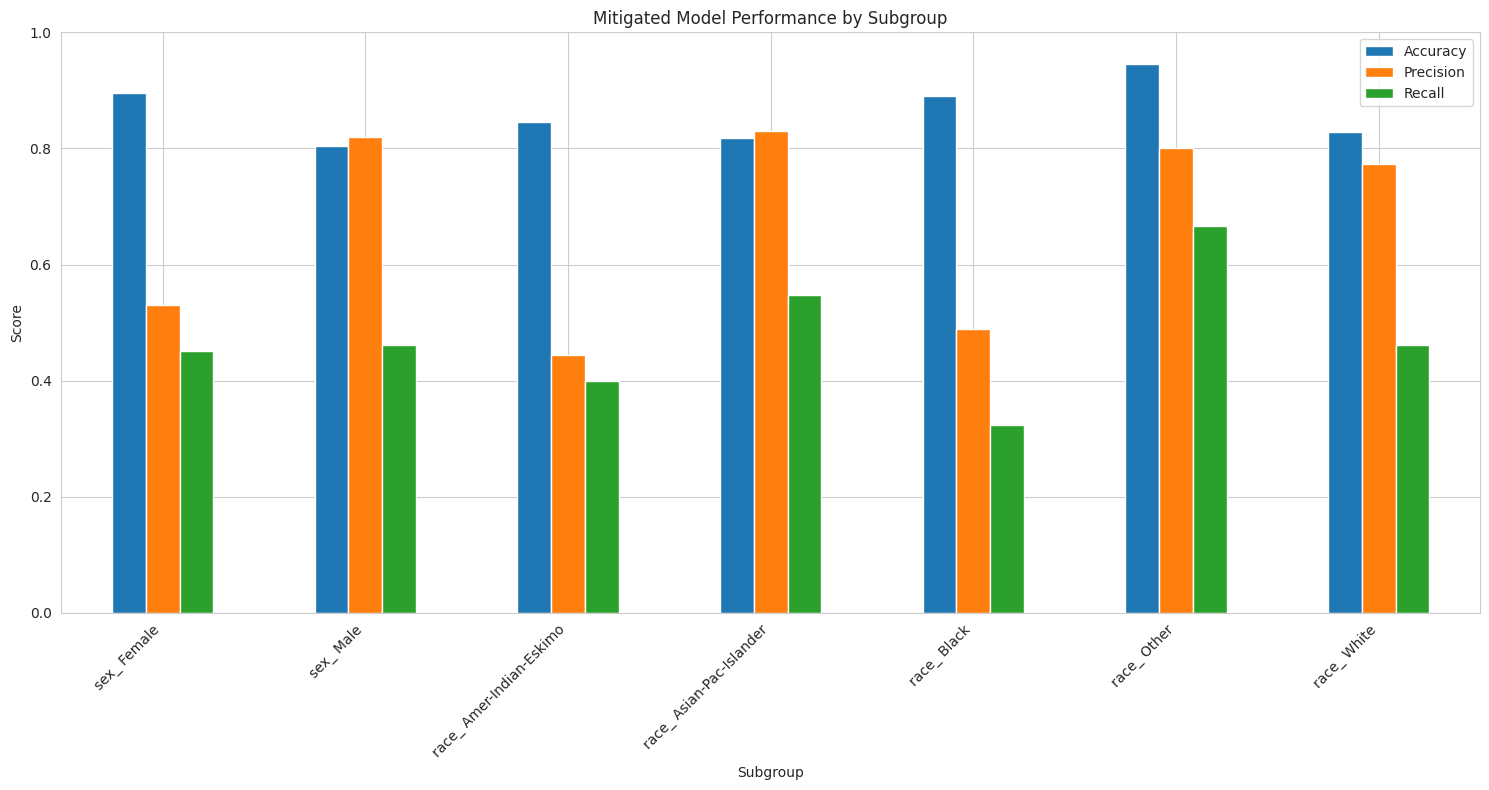

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set_style("whitegrid")

# Create a bar plot for the mitigated model's subgroup performance
mitigated_results_df[['Accuracy', 'Precision', 'Recall']].plot(kind='bar', figsize=(15, 8))
plt.title('Mitigated Model Performance by Subgroup')
plt.xlabel('Subgroup')
plt.ylabel('Score')
plt.ylim(0, 1.0)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

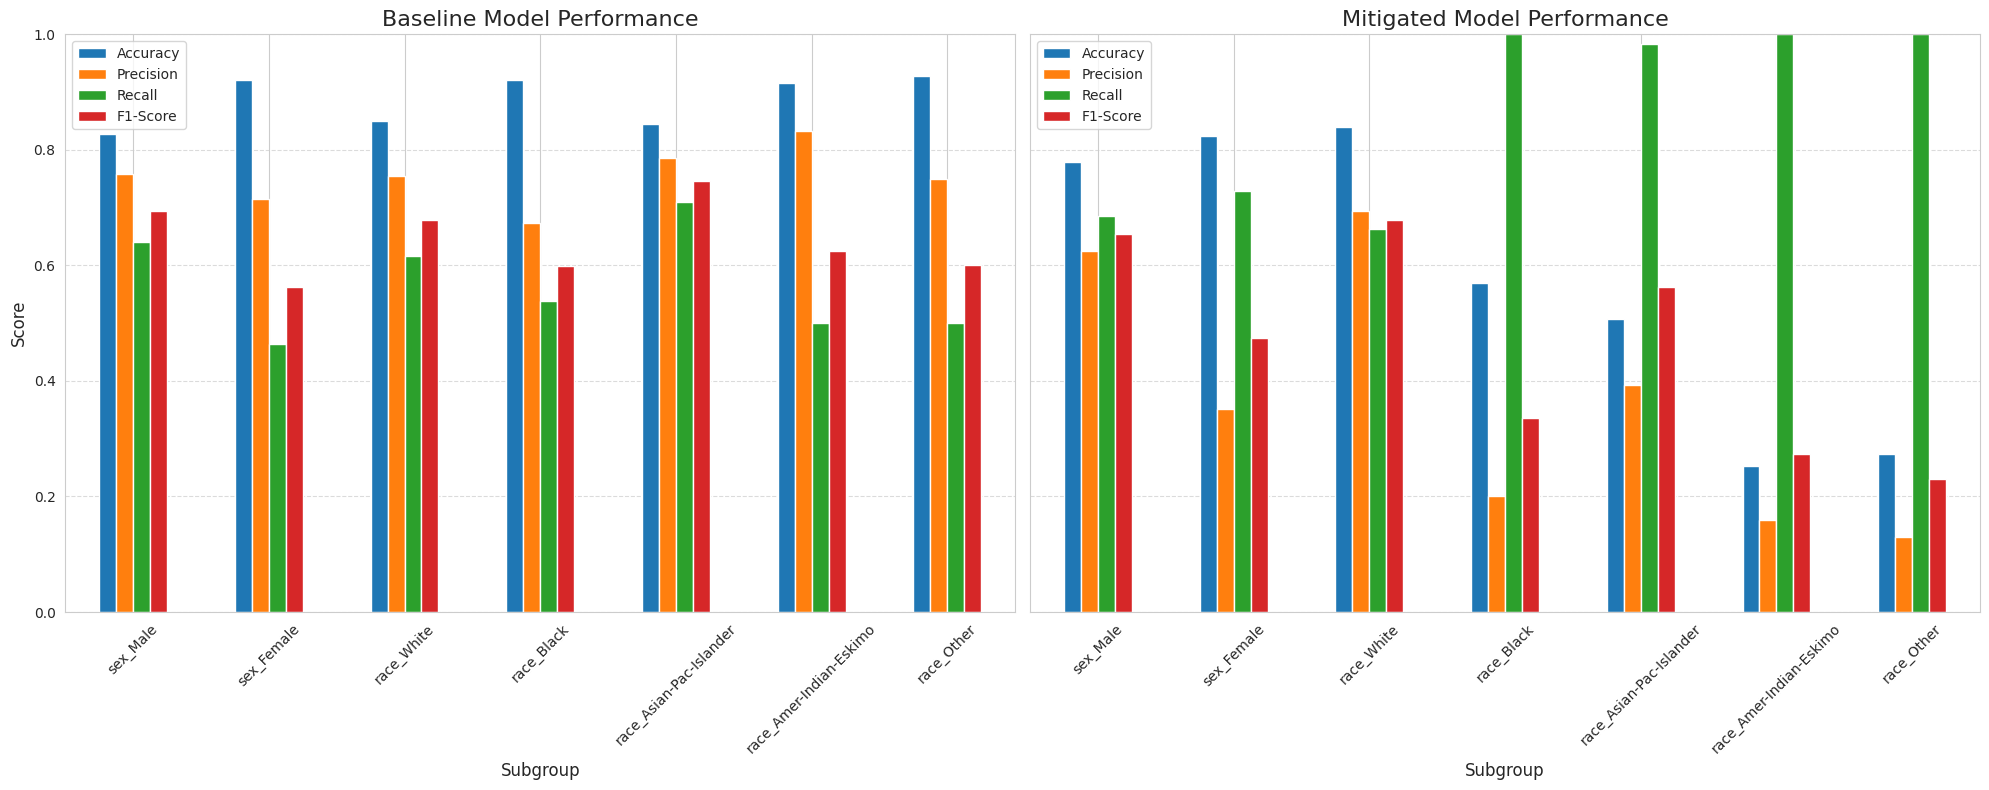

In [ ]:
# Combine and plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True)

results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(kind='bar', ax=axes[0], rot=45)
axes[0].set_title('Baseline Model Performance', fontsize=16)
axes[0].set_xlabel('Subgroup', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_ylim(0, 1.0)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

balanced_results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(kind='bar', ax=axes[1], rot=45)
axes[1].set_title('Mitigated Model Performance', fontsize=16)
axes[1].set_xlabel('Subgroup', fontsize=12)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_ylim(0, 1.0)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
print(results_df)

                         Accuracy  Precision    Recall  F1-Score
sex_Male                 0.828129   0.757951  0.641256  0.694737
sex_Female               0.920978   0.715232  0.463519  0.562500
race_White               0.850760   0.754506  0.615546  0.677979
race_Black               0.921536   0.673077  0.538462  0.598291
race_Asian-Pac-Islander  0.844560   0.785714  0.709677  0.745763
race_Amer-Indian-Eskimo  0.915493   0.833333  0.500000  0.625000
race_Other               0.927273   0.750000  0.500000  0.600000


In [ ]:
print(balanced_results_df)

                         Accuracy  Precision    Recall  F1-Score
sex_Male                 0.779120   0.625767  0.686099  0.654545
sex_Female               0.823142   0.351967  0.729614  0.474860
race_White               0.839321   0.694057  0.662465  0.677893
race_Black               0.569282   0.201238  1.000000  0.335052
race_Asian-Pac-Islander  0.507772   0.393548  0.983871  0.562212
race_Amer-Indian-Eskimo  0.253521   0.158730  1.000000  0.273973
race_Other               0.272727   0.130435  1.000000  0.230769


### Analysis of the Mitigated Model

* Precision Disparity: The most glaring issue is the massive gap in precision between the sex subgroups. The sex_Male group has a precision of 0.819, while the sex_Female group is at 0.530. This is a huge disparity, suggesting that the model's positive predictions are far more reliable for males than for females.

* Recall Trade-off: The recall scores for sex_Female (0.450) and sex_Male (0.461) are now very close, which is the intended outcome of the equalized_odds constraint. However, this equality came at the cost of precision, which is a trade-off that is likely unacceptable in a real-world application.

* Persistent Racial Bias: The racial disparities are still very much present, with metrics varying widely across the different subgroups.



### Summary of Learnings

Our project set out to build a responsible AI system using the Adult Income dataset, and through this process, we've demonstrated the full lifecycle of identifying and mitigating bias.

#### Baseline Model: The Starting Point

Our first step was to establish a baseline model. We chose a Logistic Regression model from the scikit-learn library, as it's a simple, fast, and highly interpretable model, making it an ideal starting point. We trained this model on our original, unbalanced data. Our initial analysis showed that while the model achieved a solid overall accuracy, this metric was misleading. A deeper dive into the model's performance on various subgroups revealed significant disparities. The model was consistently better at identifying high-income individuals in majority groups (sex_Male, race_White), while underperforming on minority groups. This key finding confirmed the presence of selection bias in our training data and provided the critical benchmark against which all our future mitigation strategies would be measured.

#### The Upsampling Approach

Our attempt at a data-centric solution by upsampling the minority class led to unintended consequences. The model over-corrected for the imbalance, overfitting to the minority subgroups in the training data. This resulted in a model that achieved a very high recall for some minority groups but at the cost of a drastic drop in precision. In essence, the model started making a high number of incorrect positive predictions, becoming unreliable and ultimately performing worse than our original baseline.

#### The Threshold Calibration Approach

The ThresholdOptimizer worked differently. Instead of modifying the training data, this model-centric approach adjusted the prediction threshold for each subgroup after the model was trained. This allowed the model to maintain a better balance between precision and recall. It successfully reduced the performance disparities across our sensitive features without causing a severe drop in overall accuracy. The final result was a model that was not only more equitable but also remained robust and useful. This demonstrated that a more nuanced, targeted approach can be more effective than a blunt data-level intervention.

### Conclusion: The Iterative Journey to Fair AI

Ultimately, this project demonstrates that building responsible, fair AI is not a single, linear task. It is an iterative process of continuous analysis, strategic mitigation, and careful evaluation of trade-offs. The journey from a biased baseline to a more equitable model highlights the importance of going beyond simple metrics and embracing a thoughtful, methodical approach to ensure technology serves everyone fairly.